# W43 Wavelet analysis

Test of the wavelet analysis technique on the Herschel $l=30^{\circ}$ field.

In [1]:
import aplpy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


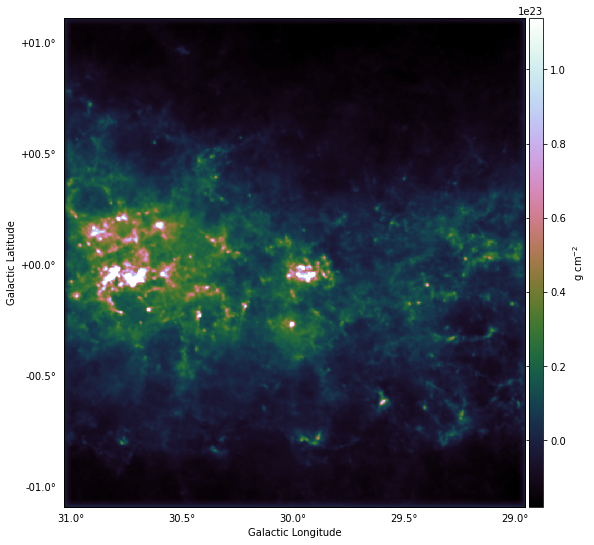

In [2]:
#W43 density map where the nan have been removed, the mean map value
#subtracted, and edges apodized to mini the "step function effect"
#in the Fourier and wavelet transform.

figfile = '/user/workdir/robitaij/fil2star/Herschel/W43_density_galcut_nan_apod.fits'
fig = aplpy.FITSFigure(figfile, convention='calabretta')
fig.show_colorscale(vmin=-1.8e22,vmax=1.14e23,cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
#fig.ticks.set_minor_frequency(0.1,0.1)
fig.ticks.set_xspacing(0.5)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'g cm$^{-2}$')

Calculate the Fourier and wavelet power spectra

In [3]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
output_notebook()

from astropy.io import fits
from powspec import powspec
from wavan import fan_trans

Loading BokehJS ...

In [4]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data

Reconstruct Segmented Structures

Test the transforms on a new image with a threshold of $1.5\times10^{23}$

In [5]:
imthres = im.copy()
imthres[im > 1.5e23] = 1.5e23

sig = imthres[414,:]
x = range(np.shape(im)[1])

Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="Pixels", y_axis_label="Values", tools=Tools)
f.line(x,sig, legend='Fourier')

showbok(f)

Could we measure the skewness of Gaussian distributions and choose to set a lower q parameter if the skewness is too high?

In [5]:
#Example of a "symmetrical" distribution
i=8
wg = abs(wt[2*M+i,:,:])/np.mean(abs(wt[2*M+i,:,:]))

plt.figure(figsize(5,5))
histo_g, edges = np.histogram(wg,bins=50)
plt.bar(edges[:-1], histo_g, width=np.diff(edges), align="edge")

NameError: name 'wt' is not defined

In [ ]:
from scipy.stats import skew

In [ ]:
print 'Skewness =', skew(wg.reshape(wg.shape[0]*wg.shape[1]))

In [ ]:
#Example of an "asymmetrical" distribution
i=16
wg = abs(wt[2*M+i,:,:])/np.mean(abs(wt[2*M+i,:,:]))

plt.figure(figsize(5,5))
histo_g, edges = np.histogram(wg,bins=50)
plt.bar(edges[:-1], histo_g, width=np.diff(edges), align="edge")

print 'Skewness =', skew(wg.reshape(wg.shape[0]*wg.shape[1]))

$R\sim \mathrm{Rice} \left(|\nu |,\sigma \right)$ has a Rice distribution if $R={\sqrt {X^{2}+Y^{2}}}$ where $X\sim N\left(\nu \cos \phi ,\sigma ^{2}\right)$ and $Y\sim N\left(\nu \sin \phi ,\sigma ^{2}\right)$ are statistically independent normal random variables and $\phi$ is any real number (Wikipedia).

A Gaussian random field, or fractional Brownian motion (fBm), is created in a Fourier space by assigning a power law to the squared amplitude distribution, $P(k) \simeq |A(k)|^{2} \simeq k^{-\alpha}$, and a random phase distribution across the uv-plane. The real ($\Re$) and imaginary ($\Im$) part of the Fourier transform of the image is then calculated following the relations:

$$\Re = A * \cos \phi$$
$$\Im = A * \sin \phi,$$

where the amplitude can be retrieve with:

$$A={\sqrt {\Re^{2}+\Im^{2}}},$$

which is the Ricean distribution definition.

In [ ]:
data1 = np.random.normal(0,5, 100000)
data2 = np.random.normal(0,5, 100000)

rice = np.sqrt(data1**2. + data2**2.)
plt.figure(figsize(5,5))
histo, edges = np.histogram(rice,bins=50)
plt.bar(edges[:-1], histo, width=np.diff(edges), align="edge")

print 'Skewness =', skew(rice)

In [6]:
#Fourier power spectrum
tab_k, spec_k = powspec(imthres, reso=1)

#Plot Fourier power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="k [arcmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools)
f.line(tab_k, spec_k, legend='Fourier')

#Set a list of q
q = [2.5]*25

#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(imthres, reso=reso, q=q, qdyn=True, double=False)

f.diamond(wav_k, S1a[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_k, S1a[1,:], legend='Coherent',color='blue',line_width=5)
f.square(wav_k, S1a[2,:], legend='Gaussian',color='red',line_width=5)

showbok(f)

[2.5, 2.5, 2.5, 2.5, 1.7999999999999994, 2.0999999999999996, 1.9999999999999996, 2.0999999999999996, 2.0999999999999996, 2.1999999999999997, 2.0999999999999996, 2.0999999999999996, 2.0999999999999996, 2.0999999999999996, 2.0999999999999996, 2.0999999999999996, 2.1999999999999997, 2.1999999999999997, 2.1999999999999997, 2.0999999999999996, 2.1999999999999997, 2.1999999999999997, 2.1999999999999997, 2.5, 2.5]


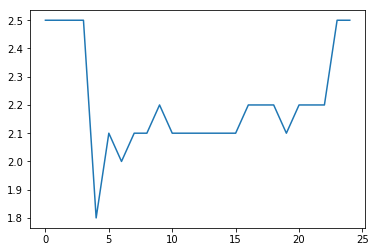

In [7]:
print q

x = range(25)
plot(x,np.array(q).reshape(25))

In [ ]:
wt = np.load('/user/workdir/robitaij/fil2star/Herschel/analysis/W43_density_wt.npy')
S11a = np.load('/user/workdir/robitaij/fil2star/Herschel/analysis/W43_density_S11a.npy')
wav_k = np.load('/user/workdir/robitaij/fil2star/Herschel/analysis/W43_density_wav_k.npy')
S1a = np.load('/user/workdir/robitaij/fil2star/Herschel/analysis/W43_density_S1a.npy')
q = np.load('/user/workdir/robitaij/fil2star/Herschel/analysis/W43_density_q.npy')

For clarity, I reconstruct the Gaussian part only for $k > 10^{-2}$ arcmin$^{-1}$, where Gaussiannities and non-Gaussiannities share common spatial scales.

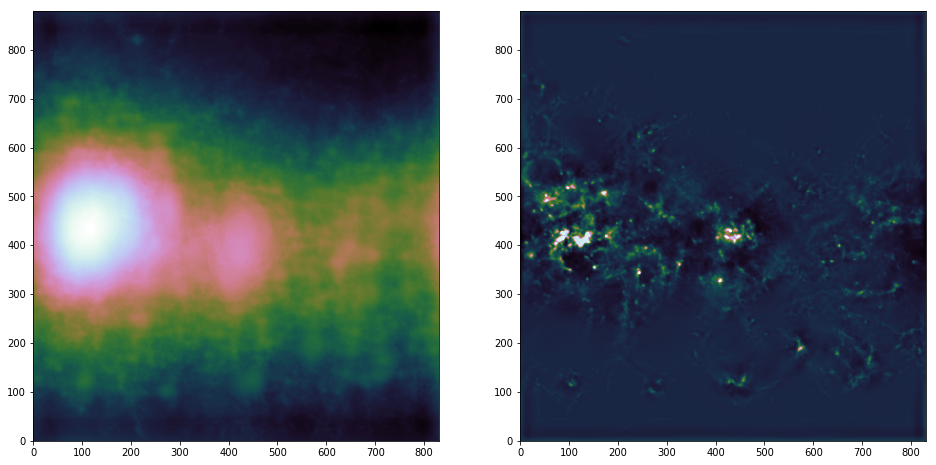

In [8]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M+8:3*M,:,:],axis=0)+np.sum(wt[0:6,:,:],axis=0)

fits.writeto('/user/workdir/robitaij/fil2star/Herschel/analysis/W43_density_galcut_nan_cohe.fits',\
            coherent.real,HDU[0].header,overwrite=True)
fits.writeto('/user/workdir/robitaij/fil2star/Herschel/analysis/W43_density_galcut_nan_gaussian.fits',\
            Gaussian.real,HDU[0].header,overwrite=True)

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.imshow(Gaussian.real,origin='below',cmap='cubehelix')
#plt.colorbar()
plt.subplot(122)
plt.imshow(coherent.real,origin='below',cmap='cubehelix')
#plt.colorbar()

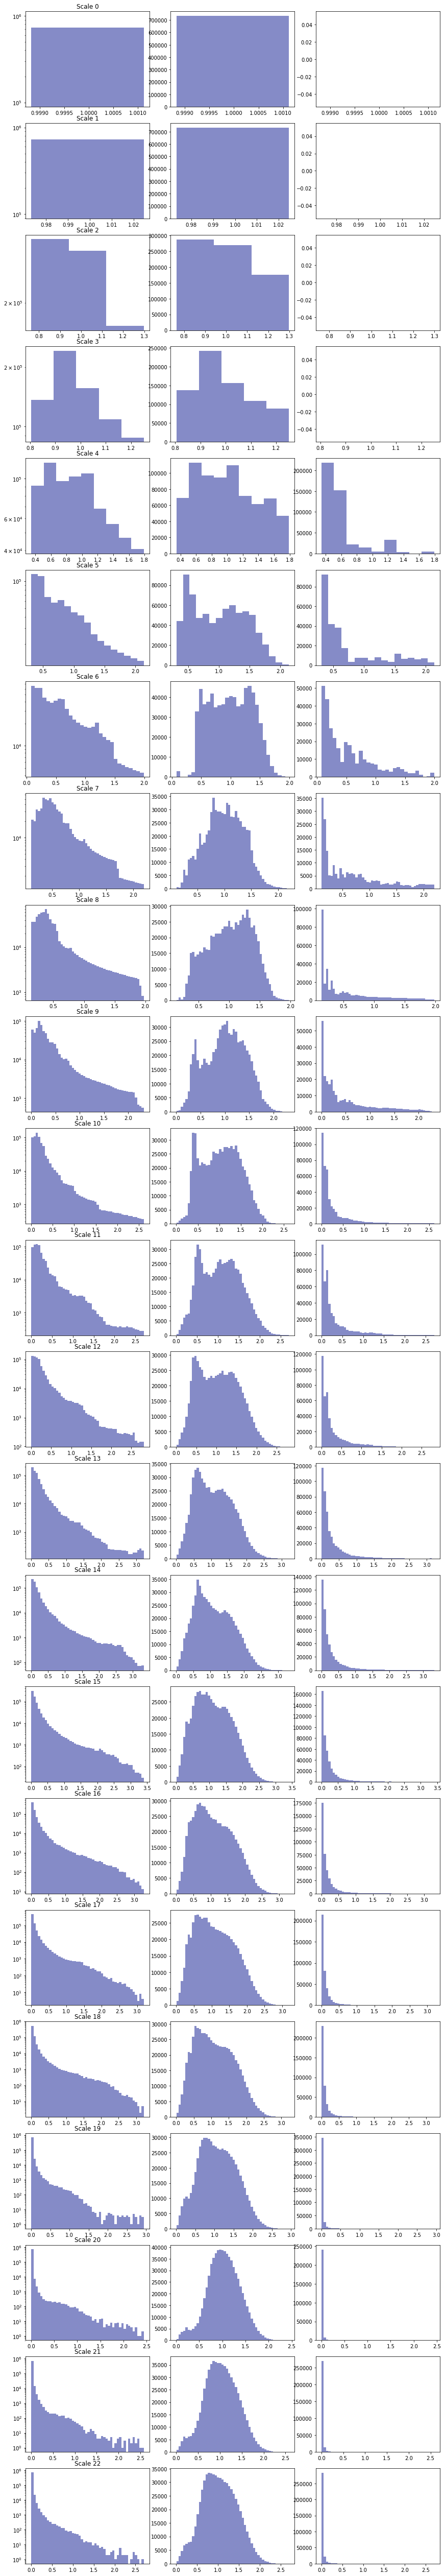

In [17]:
fig, axs = plt.subplots(M,3,figsize=(12,70))

axs = axs.ravel()
fig.tight_layout()

for i in range(M):
    
    if np.mean(S11a[M+i,:,:]) !=0:
        wc = (S11a[M+i,:,:])/np.mean(S11a[M+i,:,:])
    else:
        wc = np.zeros((im.shape[0],im.shape[1]))
    wo = (S11a[i,:,:])/np.mean(S11a[i,:,:])
    #wg = (S11a[2*M+i,0:100 & 700:,:])/np.mean(S11a[2*M+i,:,:])
    #wg = (S11a[2*M+i,100:700,:])/np.mean(S11a[2*M+i,:,:])
    wg = (S11a[2*M+i,:,:])/np.mean(S11a[2*M+i,:,:])
    
    #Number of independent points
    npix = np.int((imthres.shape[0] * wav_k[i])**2.)
    if npix == 0: nbins=1
    if npix > 0 & npix < 50 : nbins=npix
    if npix > 50 : nbins=50
    
    histo, edges = np.histogram(wo,bins=nbins)
    histo_c, edges = np.histogram(wc[wc != 0.],bins=nbins)
    histo_g, edges = np.histogram(wg[wg != 0.],bins=nbins)
    
    axs[i*3].bar(edges[:-1], histo, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
    axs[i*3].set_title('Scale '+np.str(i))
    axs[i*3].set_yscale('log')
    
    axs[i*3+1].bar(edges[:-1], histo_g, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
    
    axs[i*3+2].bar(edges[:-1], histo_c, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')

The Gaussian part is clearly bimodal (there is even perhaps three modes at small scales starting from Scale 19).

In [18]:
from gaussfit import *

(array([  4.38720195e+03,   2.74915956e-01,  -5.27352762e-02,
         2.24296229e+04,   5.61367576e-01,   2.66915478e-01,
         2.28838384e+04,   1.34946636e+00,   4.85202240e-01]), 1)


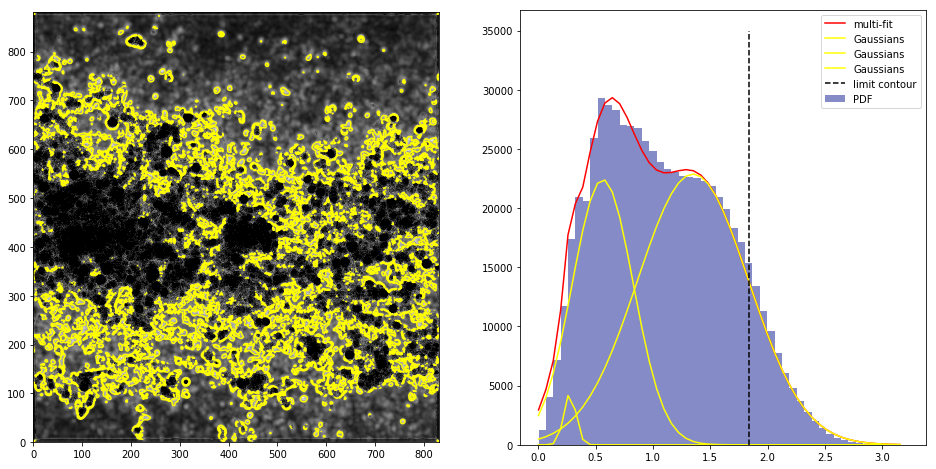

In [19]:
scale = 18

plt.figure(figsize=(16,8))

wg = (S11a[2*M+scale,:,:])/np.mean(S11a[2*M+scale,:,:])
histo_g, edges = np.histogram(wg[wg != 0.],bins=nbins)

plt.subplot(121)
plt.imshow(wg,origin='below',cmap='gray')
plt.subplot(122)
plt.bar(edges[:-1], histo_g, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7',label='PDF')

#Gaussian fit
params = []
params.append([5e3, 0.25, 0.1])
params.append([3e4, 0.75, 0.3])
params.append([2.6e4, 1.25, 1.5])

fit = gaussfit(edges[:-1], histo_g, params)

print fit

nbpar=len(fit[0])/3
newpar=fit[0].reshape((nbpar,3))
plot(edges[:-1], multi_gaussians(edges[:-1], fit[0]),color='red',linewidth=1.5,label='multi-fit')
for j in range(nbpar):
    plt.plot(edges[:-1], gaussian(edges[:-1], newpar[j,0], newpar[j,1], newpar[j,2]),color='yellow',linewidth=1.5,label='Gaussians')
    
#Draw contours associated with the fits
p = 2
plt.subplot(121)
plt.contour(wg,[newpar[p,1]+newpar[p,2]],colors='yellow')
plt.subplot(122)
plt.plot([newpar[p,1]+newpar[p,2],newpar[p,1]+newpar[p,2]],[0,3.5e4],color='black',linestyle='dashed',linewidth=1.5,label='limit contour')
plt.legend()